In [ ]:
!nvidia-smi

Wed Apr  9 15:09:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |    1150MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install -q ultralytics roboflow

In [ ]:
from roboflow import Roboflow
from google.colab import userdata
from IPython.display import Image

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vMvWjKfWllUx4W6EPyoK")
project = rf.workspace("great-0js6k").project("football-players-detection-3zvbc-nmj9m")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-1 in yolov8:: 100%|██████████| 756/756 [00:00<00:00, 1991.88it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

In [ ]:
import os
from google.colab import userdata

# os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

In [ ]:
!pip install -q gdown inference-gpu

In [ ]:
!pip install -q git+https://github.com/roboflow/sports.git

  Preparing metadata (setup.py) ... done


In [ ]:
!pip list | grep supervision

supervision                        0.25.1


In [ ]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

In [ ]:
from inference import get_model
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/11"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

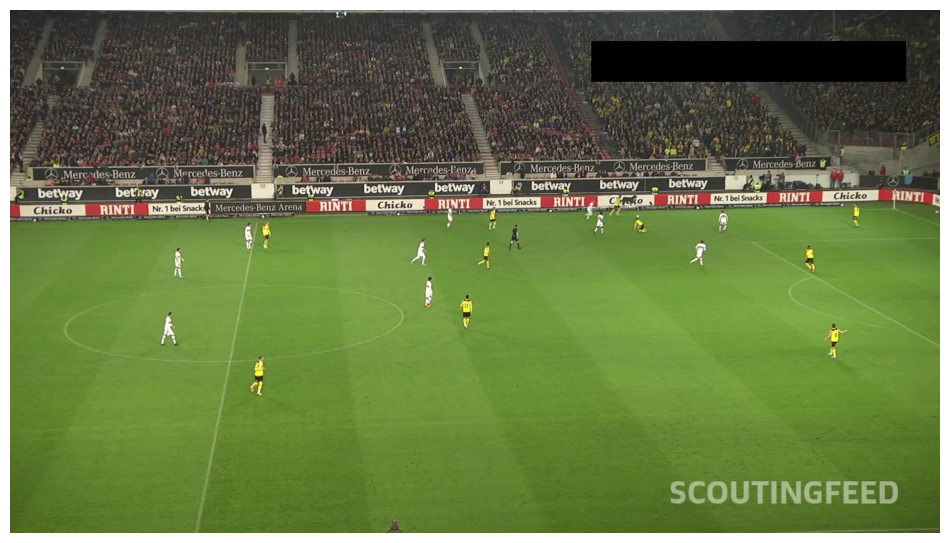

In [ ]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/test (14).mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

In [ ]:
import supervision as sv
from tqdm import tqdm
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/test (14).mp4"
TARGET_VIDEO_PATH= "/content/result.mp4"
box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

video_info=sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink=sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# frame = next(frame_generator)

with video_sink:
  for frame in tqdm(frame_generator,total=video_info.total_frames):
      result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
      detections = sv.Detections.from_inference(result)

      labels = [
          f"{class_name} {confidence:.2f}"
          for class_name, confidence
          in zip(detections['class_name'], detections.confidence)
      ]

      annotated_frame = frame.copy()
      annotated_frame = box_annotator.annotate(scene=annotated_frame,detections=detections)
      annotated_frame = label_annotator.annotate(scene=annotated_frame,detections=detections,labels=labels)
      video_sink.write_frame(annotated_frame)


100%|██████████| 750/750 [03:37<00:00,  3.44it/s]
